In [34]:
from scipy.io import arff
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.offline import plot

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt

from helper import get_report_df

data = arff.loadarff('messidor_features.arff')
df = pd.DataFrame(data[0])
df.columns = ["quality", "prescreen", 
              "ma_detection_0.5", "ma_detection_0.6", "ma_detection_0.7", 
              "ma_detection_0.8", "ma_detection_0.9", "ma_detection_1.0",
              "exudates_0.1", "exudates_0.2", "exudates_0.3",
              "exudates_0.4", "exudates_0.5", "exudates_0.6",
              "exudates_0.7", "exudates_0.8",
              "dist_macula_optic", "diameter_optic", "am_fm", "Class"
             ]

In [17]:
#Data Cleansing
df["Class"] = [j.replace("b", "").replace("'", "") for j in df["Class"].astype(str)]
df["Class"] = df["Class"].astype(int)
df["Class"].head()

0    0
1    0
2    1
3    0
4    1
Name: Class, dtype: int32

In [18]:
#Partioning Data
Y = df.iloc[:, -1]
X = df.iloc[:, :-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, stratify = Y, random_state = 123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(y_train.mean(), y_test.mean())

(690, 19) (461, 19) (690,) (461,)
0.5304347826086957 0.5314533622559653


In [22]:
%%time
RF = RandomForestClassifier(max_leaf_nodes=16,n_jobs=-1)
param_grid = {"n_estimators": np.arange(5,100,5)}
rf_grid_cv = GridSearchCV(RF, param_grid, cv=5)
#fit model to data
rf_grid_cv.fit(x_train, y_train)
print('Best n_estimators:', rf_grid_cv.best_params_['n_estimators'])
print('Best Score:', rf_grid_cv.best_score_)

Best n_estimators: 35
Best Score: 0.6623188405797101
Wall time: 19.3 s


Text(0.5, 1.0, 'CV Mean Accuracy vs n_estimators')

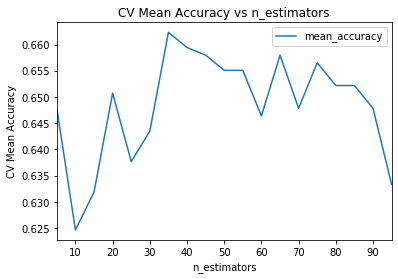

In [24]:
#Data Frame 

rf_df = pd.DataFrame(dict(n_estimators = param_grid["n_estimators"], mean_accuracy = rf_grid_cv.cv_results_["mean_test_score"]))
rf_df.plot(x = "n_estimators", y = "mean_accuracy")
plt.xlabel("n_estimators")
plt.ylabel("CV Mean Accuracy")
plt.title("CV Mean Accuracy vs n_estimators")



In [35]:
y_train_pred= rf_grid_cv.predict(x_train)
y_test_pred= rf_grid_cv.predict(x_test)

report_train = classification_report(y_train, y_train_pred, output_dict = True)
report_test = classification_report(y_test, y_test_pred, output_dict = True)

report_train_df = get_report_df(report_train, label = "training")
report_test_df = get_report_df(report_test, label = "testing")

report_df = pd.concat([report_train_df, report_test_df])
report_df


,precision,recall,f1,accuracy,sample
0,0.840979,0.751366,0.793651,0.792754,training
0,0.683544,0.661224,0.672199,0.657267,testing
